# Time Series Homework

In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show, export_png
# from bokeh.io import output_file
from bokeh.plotting import figure
from itertools import chain 
from sklearn.metrics import mean_squared_error
import datetime as dt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg
# import pmdarima as pm

import math
# import pmdarima as pm
import statsmodels.api as sm
def mean_absolute_percentage_error(y_true, y_pred): 
     return np.mean(np.abs((y_true - y_pred) / y_true)) *100
output_notebook()

Loading BokehJS ...

## Problem 3

We will first read the two files given to us into dataframes that we can work with

In [2]:
ps_cpi = pd.read_csv("PriceStats_CPI.csv")
ps_cpi['date'] =pd.to_datetime(ps_cpi['date'])
ps_cpi.head(10)

,date,PriceStats,CPI
0,2008-07-24,100.00000,100.0000
1,2008-07-25,99.99767,100.0000
2,2008-07-26,99.92376,100.0000
3,2008-07-27,99.91537,100.0000
4,2008-07-28,99.89491,100.0000
5,2008-07-29,99.88470,100.0000
6,2008-07-30,99.88448,100.0000
7,2008-07-31,99.86741,100.0000
8,2008-08-01,99.85761,100.5251
9,2008-08-02,99.85294,100.5251


Notice that while PriceStats changes on a daily basis, CPI only changes on a monthly basis. Hence, the monthly CPI can be obtained by taking the CPI of any day during a month. Additionally, we split the data into training and testing data sets as outlined in the problem statement

In [3]:
# cpi_monthly = pd.DataFrame(columns =['Month','CPI'])
ps_cpi['YearMonth'] = ps_cpi['date'].dt.strftime('%Y-%m')
cpi =ps_cpi.drop_duplicates('YearMonth', keep='last').copy().reset_index().drop(['index','PriceStats'],axis=1)
cpi_train = (cpi[cpi.YearMonth<'2013-09'].copy())
cpi_test = (cpi[cpi.YearMonth >='2013-09'].copy())
# cpi_train.CPI = np.log(cpi_train.CPI)
# cpi_test.CPI = np.log(cpi_test.CPI)
cpi.head(10)


,date,CPI,YearMonth
0,2008-07-31,100.00000,2008-07
1,2008-08-31,100.52510,2008-08
2,2008-09-30,100.12380,2008-09
3,2008-10-31,99.98538,2008-10
4,2008-11-30,98.97539,2008-11
5,2008-12-31,97.07973,2008-12
6,2009-01-31,96.07569,2009-01
7,2009-02-28,96.49385,2009-02
8,2009-03-31,96.97369,2009-03
9,2009-04-30,97.20951,2009-04


Visualize the time series

In [4]:
p = figure(plot_width=400, plot_height=400, title = "Monthly CPI")
p.line(cpi_train.index,cpi_train.CPI,line_color="navy",line_width =2.5)
p.xaxis.axis_label ='t'
p.yaxis.axis_label ='CPI'
show(p)

From the visualization, it is clear that the timeseries has a deterministic trend. We try and fit a linear model to the data (as in the question above) and see if this is sufficient to represent the trend. We then subtract this trend from the data.


In [5]:
model = LinearRegression().fit(np.array(cpi_train.index).reshape(-1, 1),cpi_train.CPI)
coefficients = [model.coef_[0],model.intercept_]
print("The linear trend is given by F(t) = " +str(coefficients[0])+"*t + (" +str(coefficients[1])+")")
linear_cpi =model.predict(np.array(cpi_train.index).reshape(-1, 1))
p = figure(plot_width=400, plot_height=400, title = "CPI Time Series")
p.line(cpi_train.index,cpi_train.CPI, line_color="navy", line_width=2, legend_label ="Original Data")
p.line(cpi_train.index,linear_cpi, line_color="orange",line_width=2.5,legend_label ="Linear Trend")

p.xaxis.axis_label ='t'
p.yaxis.axis_label ='CPI'
p.legend.location='bottom_right'
show(p)

The linear trend is given by F(t) = 0.16104348366951224*t + (96.72932632872502)


We now subtract this linear trend from the data. When prompted to 'Choose Method:' in the following part, please type 'linear'

> $\textit{Note :}$ An alternative to detrending the data in this manner would be to take first difference. Economists tend to log transform the CPI data and then take the first difference in order to detrend it. While the problem set only asks for the linear trend to be removed from the data, the code below allows you to visualize what the first difference of log transform looks like as well. In order to see this, please enter "log" when asked to choose method. Please remember to run the block again with the method as linear to proceed with the next part of the PSET.

In [6]:
x = input('Choose Method:')
if x == 'linear':
    remaining = cpi_train.CPI - linear_cpi
    linear_cpi_test = model.predict(np.array(cpi_test.index).reshape(-1, 1))
    remaining_test = cpi_test.CPI - linear_cpi_test
    test = cpi_test.index
    train = cpi_train.index
else:
    cpi_diff_log = np.log(cpi.CPI).diff()
    remaining = cpi_diff_log[0:cpi_train.shape[0]]
    remaining.iloc[0] = 0    
    #.reset_index()#.drop(['index'],axis =1)
    remaining_test = cpi_diff_log[cpi_train.shape[0]:].dropna()
    remaining_test.iloc[0] = 0
    test = cpi_test.index
    train = cpi_train.index


    
p = figure(plot_width=400, plot_height=400, title = "CPI Time Series")
p.line(train,remaining, line_color="navy", line_width=2, legend_label ="Detrended Data")



# p.line(cpi_diff.index,cpi_diff,line_color="green",line_width =2.5)
show(p)
print("the maximum residual value is:"+str(np.max(remaining)))

Choose Method:linear


the maximum residual value is:3.634730187605456


Note that at some stage, we will be required to add back the trend to the data. The function $\texttt{rebuild_diffed()}$ below has been designed for this purpose. We will be calling this function later.

In [7]:
def rebuild_diffed(series, first_element_original,x,linear_trend):
    if x == 'linear':
        final = series + linear_trend
    else:
        cumsum = pd.Series(series).cumsum()
        final = np.exp(cumsum.fillna(0) + first_element_original)
        if first_element_original == 0:
            final = np.exp(cumsum.fillna(0))
    return final

As there seems to be no other trend present in this residual, we can take the linear trend to be sufficient and move to the next step, i.e. to deseasonalize the data. However, the above visualization seems to indicate no clear seasonality. Hence, we directly proceed to fitting an AR Model on the residual. To do so, we first plot the autocorrelation and partial autocorrelation plots.

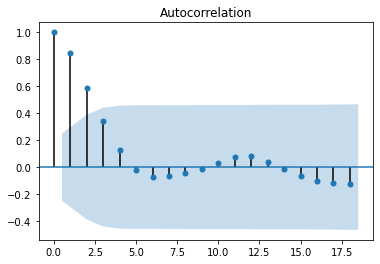

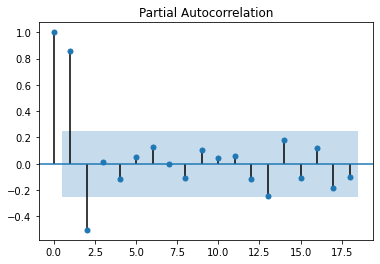

In [8]:
#linear
plot_acf(remaining)
plt.show()
plot_pacf(remaining)
plt.show()

From the above PACF plot, we can see that the highest lag at which the plot extends beyond the statistically significant boundary is at lag 2. This indicates that an AR Model of lag 2 should be sufficient to fit the data. However, we can further verify this by calculating the rmse of the fit

In [9]:
rmse_train=[]

for n in range(1,8):
    model = AutoReg(remaining, lags= n,trend='n')
    model_fit = model.fit()
    predictions=model_fit.predict()
    rmse=(mean_squared_error(remaining[n:], predictions[n:]))**0.5
    rmse_train.append(rmse)

    
    
p = figure(plot_width=400, plot_height=400, title = "RMSE of AR Models of order n")
p.scatter(np.arange(1,8),rmse_train,size = 15, marker ="square", line_color="navy",fill_color="orange", fill_alpha =0.5, legend_label ="RMSE")
p.xaxis.axis_label ='n'
p.yaxis.axis_label ='RMSE'
p.legend.location='top_right'
show(p)




In [10]:
#plot RMSE for a range of lags p 
n = 2
rmse_ar=[]
for n in range(1,8):
    model = AutoReg(remaining, lags= n)
    model_fit = model.fit()
    coef = model_fit.params
    past = remaining[len(remaining)-n:].values
    past = [past[i] for i in range(len(past))]    
    test_predictions = list()
    for t in range(len(remaining_test.dropna())):
        length = len(past)
        lag = [past[i] for i in range(length-n,length)]
        pred = coef[0]
        for d in range(n):
            pred += coef[d+1] * lag[n-d-1]
        obs = remaining_test.values[t]
        test_predictions.append(pred)
        past.append(obs)
    rmse = (mean_squared_error(remaining_test.dropna(), test_predictions))**0.5
    rmse_ar.append(rmse)
    print('Test RMSE for AR(' + str(n) +'):' + str(rmse))
p = figure(plot_width=400, plot_height=400, title = "RMSE of AR Models of order n")
p.scatter(np.arange(1,8),rmse_ar,size = 15, marker ="square", line_color="navy",fill_color="orange", fill_alpha =0.5, legend_label ="RMSE")
p.xaxis.axis_label ='n'
p.yaxis.axis_label ='RMSE'
p.legend.location='bottom_right'
show(p)

Test RMSE for AR(1):0.3718449350821093
Test RMSE for AR(2):0.39328060138088866
Test RMSE for AR(3):0.3784955272936298
Test RMSE for AR(4):0.44251979719237056
Test RMSE for AR(5):0.43456315263365036
Test RMSE for AR(6):0.34020763928627823
Test RMSE for AR(7):0.31251327073280627


The plot above seems to indicate the AR(1) model predictions have the least rmse. While it would have been ideal to have our previous conclusion of model order 2 validated by the RMSE, we should note this kind of discrepancy between the two diagnostic methods (rmse and PACF) can occur when working with finite data sets. In order to proceed, we choose to work with model order of 2 so we do not miss out on possible lag terms.

In [11]:
## Building AR (2) Model 
n = 2
AR2_model = AutoReg(remaining, lags= n).fit()# Here we have used the default value for the trend parameter
coef = AR2_model.params
# walk forward over time steps in test
past = remaining[len(remaining)-n:].values
past = [past[i] for i in range(len(past))]
test_predictions = list()
training_predictions = AR2_model.predict(start = train[0], end =train[-1])
for t in range(len(remaining_test)):
    length = len(past)
    lag = [past[i] for i in range(length-n,length)]
    pred = coef[0]
    for d in range(n):
        pred += coef[d+1] * lag[n-d-1]
    obs = remaining_test.values[t]
    test_predictions.append(pred)
    past.append(obs)
final_training = (rebuild_diffed(training_predictions,np.log(cpi_train.CPI[0]),x,linear_cpi))
final_test = (rebuild_diffed(test_predictions,np.log(cpi_train.iloc[-1].CPI),x,linear_cpi_test))



In [31]:
p = figure(plot_width=400, plot_height=400, title = "CPI Time Series")
p.line(cpi_train.index,cpi_train.CPI, line_color="navy", line_width=2, legend_label ="Original Data")
p.line(cpi_train.index,final_training, line_color="orange",line_width=2.5,legend_label ="Linear Trend")

p.xaxis.axis_label ='t'
p.yaxis.axis_label ='CPI'
p.legend.location='bottom_right'
show(p)

We will skip the final model predictions plot until after the written report is due. 

We see that the AR(2) Model does predict pretty well and the mean squared prediction error is small. We can also reaffirm this conclusion by plotting the residuals after the AR(2) predictions are subtracted from the detrended data 

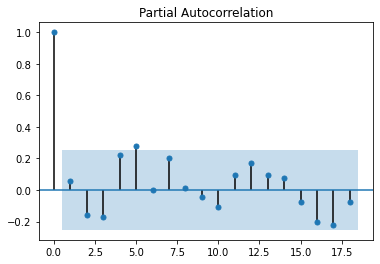

In [12]:
residuals = (remaining - training_predictions)[2:]
plot_pacf(residuals)
plt.show()

In [13]:
rmse = mean_squared_error(cpi_test.dropna().CPI,final_test[:-2])**0.5
print("The rmse of the final fit is " + str(rmse))

The rmse of the final fit is 0.39328060138088855


We see that the fit has a low rmse, considering that the order of the data is $10^2$.

**Inflation Rate**
In the next part of the question, since we will be working with external regressors that have different units(such as BER), we must first convert all the data into an equivalent form, i.e monthly inflation rates. We will first do so for CPI from which inflation rates can be simply calculated as
> $IR_t = \frac{CPI_t -CPI_{t-1}}{CPI_{t-1}}$

In [14]:
def calc_inflation_rate(data):
    ir = []
    for i in range(1,len(data)):
        ir_temp = (data[i]-data[i-1])/data[i-1] *100      
        ir.append(ir_temp)
#         print(i)
    return ir

In [34]:
#calculate monthly inflation from CPI
val = calc_inflation_rate(cpi.CPI.values)
val2=np.log(cpi.CPI).diff().values*100

cpi.loc[1:, 'IR_cpi'] = val
cpi['diff_log'] = val2
print(cpi['diff_log'])
cpi_ir_train = (cpi[cpi.YearMonth<'2013-09'].copy())
cpi_ir_test = (cpi[cpi.YearMonth >='2013-09'].copy())
print("The inflation rate from CPI for the month of February in 2013 was %0.9f" % cpi[cpi.YearMonth =='2013-02']['IR_cpi'] + " %")
print("The inflation rate from CPI for the month of February in 2013 was %0.9f" % cpi[cpi.YearMonth =='2013-02']['diff_log'] + " %")


0           NaN
1      0.523726
2     -0.400003
3     -0.138344
4     -1.015274
         ...   
132    0.019906
133    0.166955
134   -0.005117
135         NaN
136         NaN
Name: diff_log, Length: 137, dtype: float64
The inflation rate from CPI for the month of February in 2013 was 0.295722930 %
The inflation rate from CPI for the month of February in 2013 was 0.295286530 %


In [30]:
p = figure(plot_width=400, plot_height=400, title = "Monthly IR from CPI (in %)")
p.line(cpi['diff_log'].index,cpi['diff_log'],line_color="navy",line_width =2.5)
# p.line(cpi['IR_cpi'].index,cpi['IR_cpi'],line_color="orange",line_width =2.5)
# p.line(cpi_diff.index,cpi_diff,line_color="green",line_width =2.5)
p.xaxis.axis_label ='t'
p.yaxis.axis_label ='Diff Ratio CPI'
show(p)



As PriceStats varies daily, the "monthly" inflation rate can be calculated in different ways. First, we calculate the average PriceStat of the month to represent the monthly PriceStats value and then proceed to calculate monthly inflation rate using this monthly PriceStats value. To convert it to inflation rate, we use the same formula that we did for CPI
> $PS_t = \frac{PS_t -PS_{t-1}}{PS_{t-1}}$

In [18]:
ps_monthly = pd.DataFrame(columns =['YearMonth','PS'])
ps_monthly['PS'] =ps_cpi.groupby('YearMonth').PriceStats.mean().values
ps_monthly['YearMonth'] = cpi.YearMonth
val = calc_inflation_rate(ps_monthly.PS.values)
ps_monthly.loc[1:, 'IR_ps'] = val

ps_ir_train = (ps_monthly[ps_monthly.YearMonth<'2013-09'].copy())
ps_ir_test = (ps_monthly[ps_monthly.YearMonth >='2013-09'].copy())

print("The inflation rate from Avg PriceStats for the month of February in 2013 was %0.5f" % ps_monthly[ps_monthly.YearMonth == '2013-02'].IR_ps)


The inflation rate from Avg PriceStats for the month of February in 2013 was 1.03587


In [19]:
# 
p = figure(plot_width=400, plot_height=400, title = "Monthly CPI/PS")
p.line(cpi.index,cpi.CPI,line_color="navy",line_width =2.5,legend_label ="CPI")
p.line(ps_monthly.index,ps_monthly.PS,line_color="green",line_width =2.5,legend_label ="pricestats")

p.xaxis.axis_label ='t'
p.yaxis.axis_label ='CPI'
p.legend.location='bottom_right'


show(p)

In [35]:
p = figure(plot_width=400, plot_height=400, title = "Monthly IR")
p.line(cpi.index,cpi['IR_cpi'],line_color="navy",line_width =2.5)
p.line(ps_monthly.index,ps_monthly.IR_ps,line_color="green",line_width =2.5)


p.xaxis.axis_label ='t'
p.yaxis.axis_label ='CPI'
show(p)

Next, we use the PriceStat from the last day of the month to represent the monthly PriceStats value and then proceed to calculate monthly inflation rate using this monthly PriceStats value

In [21]:
# Inflation rate from pricestat last day
ps_monthly_last = pd.DataFrame(columns =['YearMonth','PS'])
ps_monthly_last =ps_cpi.drop_duplicates('YearMonth', keep='last').copy().reset_index().drop(['index','CPI'],axis=1)
val = calc_inflation_rate(ps_monthly_last.PriceStats.values)


ps_monthly_last.loc[1:, 'IR_ps_last'] = val
print("The inflation rate from Avg PriceStats for the month of February in 2013 was %0.9f" % ps_monthly_last[ps_monthly_last.YearMonth == '2013-02']['IR_ps_last']  + " %")


The inflation rate from Avg PriceStats for the month of February in 2013 was 1.159452992 %


Lastly, we first calculate daily inflation rates and use the average of these rates across a month to represent the monthly inflation rate

In [22]:
ps_cpi_temp = ps_cpi.copy()
ps_monthly_daily = pd.DataFrame(columns =['YearMonth','IR'])
val = calc_inflation_rate(ps_cpi.PriceStats.values)
ps_cpi_temp = ps_cpi_temp.drop([0])
ps_cpi_temp['Daily_PS_IR'] = [i for i in val]

ps_monthly_daily['IR'] =ps_cpi_temp.groupby('YearMonth').Daily_PS_IR.mean().values*30
ps_monthly_daily['YearMonth'] = cpi.YearMonth

ps_ir_train3 = (ps_monthly[ps_monthly.YearMonth<'2013-09'].copy())
ps_ir_test3 = (ps_monthly[ps_monthly.YearMonth >='2013-09'].copy())

print("The inflation rate from last day PriceStats for the month of February in 2013 was %0.9f" % ps_monthly_daily[ps_monthly_daily.YearMonth == '2013-02']['IR'] + " %")

The inflation rate from last day PriceStats for the month of February in 2013 was 1.235507066 %


In [23]:
#plotting the monthly inflation rates computed from CPI, and Pricestats
p = figure(plot_width=400, plot_height=400, title = "Monthly Inflation Rate in %")
p.line(cpi.index,cpi['IR_cpi'],line_color="navy",line_width =2.5)
p.line(ps_monthly.index,ps_monthly.IR_ps,line_color="green",line_width =2.5)
p.line(ps_monthly_last.index,ps_monthly_last.IR_ps_last,line_color="red",line_width =2.5)
p.line(ps_monthly_last.index,ps_monthly_daily.IR,line_color="orange",line_width =2.5)
# p.line(cpi_train.index[1:],ber_ir_train.IR_ber,line_color="red",line_width=2.5,legend_label ="BER (Avg)")


p.xaxis.axis_label ='t'
p.yaxis.axis_label ='CPI'


show(p)

In [28]:
p = figure(plot_width=800, plot_height=300, title = "Inflation Rates")
p.line(cpi_train.index[1:],ps_ir_train,line_width =2.5, line_color="black", legend_label ="PriceStats (Last Day)")
p.line(cpi_train.index[1:],ps_ir_train.IR_ps,line_width =2.5, line_color="green", legend_label ="PriceStats (Avg)")
p.line(cpi_train.index[0:],ps_ir_train3.PS,line_width =2.5, line_color="red", legend_label ="PriceStats (Avg of IR)")
p.line(cpi_train.index[0:],ps_ir_train3.PS,line_width =2.5, line_color="red", legend_label ="PriceStats (Avg of IR)")


show(p)

Now we move on to converting BER to monthly inflation rates. Just like in PriceStats, BER is reported on a daily basis. We first choose a monthly representative value by averaging the BER across all days of the month. BER is already a rate, however it is reported across a 10 year period. In order to convert this to a monthly value, we must then deannualize it using the following formula.
> $BER_t = (BER_t +1)^\frac{1}{12} -1$

In [29]:
ber = pd.read_csv('T10YIE.csv')
ber['DATE'] =pd.to_datetime(ber['DATE'])
ber['YearMonth'] = ber['DATE'].dt.strftime('%Y-%m')
ber = ber.drop(ber[ber.YearMonth< '2008-07'].index)
ber = ber.dropna()
# print(ber)

ber_monthly = pd.DataFrame(columns =['YearMonth','BER'])
ber_monthly['BER'] =ber.groupby('YearMonth').T10YIE.mean().values
ber_monthly['YearMonth'] = cpi.YearMonth
ber_monthly.drop([0])

# print(ber_monthly)
ber_ir_train = (ber_monthly[ber_monthly.YearMonth<'2013-09'].copy())
ber_ir_test = (ber_monthly[ber_monthly.YearMonth >='2013-09'].copy())


ber_ir_train['IR_ber'] = ((ber_ir_train.BER.values/100+1)**(1/12)-1)*100
ber_ir_test['IR_ber'] = ((ber_ir_test.BER.values/100+1)**(1/12)-1)*100
print("The inflation rate from BER for the month of February in 2013 was %0.9f" % ber_ir_train[ber_ir_train.YearMonth == '2013-02']['IR_ber'] + " %")

The inflation rate from BER for the month of February in 2013 was 0.210441852 %
